# 目标检测--SSD

😋😋公众号算法美食屋后台回复关键词：**torchkeras**，获取本文notebook源代码和数据集下载链接。

本例我们通过SSD模型来检测螺丝螺母。

参考文章：
* 《目标检测|SSD原理与实现》 https://zhuanlan.zhihu.com/p/33544892

参考代码:

* https://github.com/WZMIAOMIAO/deep-learning-for-image-processing

In [ ]:
!pip install git+https://github.com/lyhue1991/torchkeras

In [1]:
from torchkeras import models 
from torchkeras.models import SSD300 

In [2]:
import numpy as np
import pandas as pd 
from matplotlib import pyplot as plt
from PIL import Image,ImageColor,ImageDraw,ImageFont 

import torch
from torch import nn
import torchvision
from torchvision import datasets, models, transforms

import datetime
import os
import copy
import json 

print(torch.__version__)


1.13.0


In [3]:
import torch 
def vis_detection(image,
                   prediction,
                   class_names = None,
                   min_score=0.2,
                   figsize=(16, 16),
                   linewidth=2,
                   color = 'lawngreen'
                 ):
    
    boxes= np.array(prediction['boxes'].tolist()) 
    scores = np.array(prediction['scores'].tolist()) if 'scores' in prediction else [1.0 for _ in boxes]
    labels = np.array(prediction['labels'].tolist()) if 'labels' in prediction else None
    classes = [class_names[x] for x in labels] if (class_names is not None and labels is not None) else ['object']*len(boxes)
    
        
    import matplotlib.pyplot as plt
    image = np.array(image, dtype=np.uint8)
    fig = plt.figure(figsize=figsize)
    plt.axis("off")
    plt.imshow(image);
    ax = plt.gca()
    
    for i,(box, name, score) in enumerate(zip(boxes, classes, scores)):
        if score >= min_score:
            text = "{}: {:.2f}".format(name, score)
            x1, y1, x2, y2 = box
            w, h = x2 - x1, y2 - y1
            patch = plt.Rectangle(
                [x1, y1], w, h, fill=False, edgecolor=color, linewidth=linewidth
            )
            ax.add_patch(patch)
            ax.text(
                x1,
                y1,
                text,
                bbox={"facecolor": color, "alpha": 0.8},
                clip_box=ax.clipbox,
                clip_on=True,
            )
    plt.show();

## 一，准备数据

In [4]:
import shutil
data_url = 'https://github.com/lyhue1991/torchkeras/releases/download/v3.7.2/bult_nut.zip'
data_file = 'bult_nut.zip'

if not os.path.exists(data_file):
    torch.hub.download_url_to_file(data_url,data_file)
    shutil.unpack_archive(data_file,'data')
    
    

In [5]:
data_path = "./data/bult_nut"
print(os.listdir(data_path))

train_images_path = "./data/bult_nut/train"
train_targets_path = './data/bult_nut/train.txt'

val_images_path = "./data/bult_nut/val"
val_targets_path = './data/bult_nut/val.txt'

idx2names = {"0":"background"}
for line in open(os.path.join(data_path,"label_list.txt")):
    idx,name = line.replace("\n","").split(" ")
    idx = str(int(idx)+1)
    idx2names[idx]=name
print(idx2names) 
name2idxs = {v:int(k) for k,v in idx2names.items()}
print(name2idxs)

class_names = list(idx2names.values()) 
print(class_names)

['train.txt', 'val', '.ipynb_checkpoints', '.DS_Store', 'val.txt', 'label_list.txt', 'train']
{'0': 'background', '1': 'bolt', '2': 'nut'}
{'background': 0, 'bolt': 1, 'nut': 2}
['background', 'bolt', 'nut']


In [6]:
class BultNut(torch.utils.data.Dataset):
    def __init__(self, images_path, targets_path, transforms = None):
        self.images_path = images_path
        self.targets_path = targets_path
        self.transforms = transforms
        self.infos_list = open(targets_path,"r").readlines()

    def __getitem__(self, idx):
        
        info_str = self.infos_list[idx]
        info_arr = info_str.replace("\n","").replace("\t ","").split("\t")
        
        img_path = info_arr.pop(0)
        
        info_arr = [x for x in info_arr if x.strip()] 
        infos = [json.loads(x) for x in info_arr]

        img= Image.open(os.path.join(self.images_path,img_path)).convert("RGB")
        width,height  = img.size 
        

        target = {}
        target["image_id"] = torch.tensor([int(img_path.split(".")[0])],dtype = torch.int64)  
        target["labels"] = torch.tensor([name2idxs[x["value"]] for x in infos],
                                        dtype = torch.int64)

        coords = [x["coordinate"]  for x in infos]
        boxes = torch.tensor([[xmin/width,ymin/height,xmax/width,ymax/height] for (xmin,ymin), (xmax,ymax)  in coords])
        target["boxes"] = boxes

        target["area"] = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        target["iscrowd"] = torch.zeros((len(infos) ,), dtype=torch.int64)
        
        if self.transforms is not None:
            img, target = self.transforms(img, target)
  
        return img, target

    def __len__(self):
        return len(self.infos_list)
    

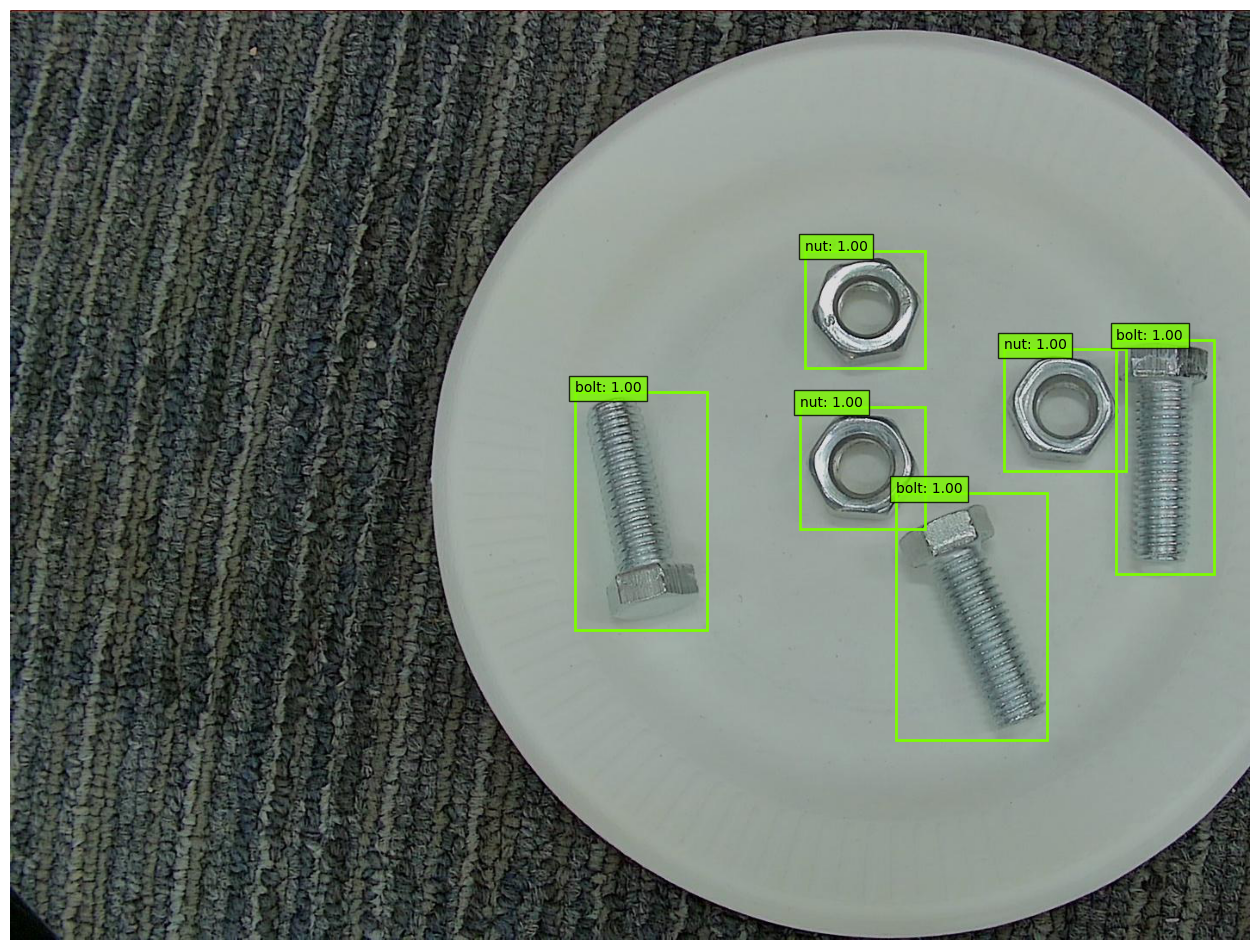

In [7]:
# 测试效果
ds_train = BultNut(train_images_path,train_targets_path)
img,target = ds_train[12]
width,height = img.width,img.height 
target['boxes'][:,0] = target['boxes'][:,0]*width
target['boxes'][:,1] = target['boxes'][:,1]*height
target['boxes'][:,2] = target['boxes'][:,2]*width
target['boxes'][:,3] = target['boxes'][:,3]*height
img_result = vis_detection(img,target,class_names,min_score = 0.8)
img_result 


下面我们设计数据增强模块

In [8]:
import random 
from torchvision import transforms as T

class Compose(object):
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, image, target):
        for t in self.transforms:
            image, target = t(image, target)
        return image, target

class Resize(object):
    """对图像进行resize处理,该方法应放在ToTensor前"""
    def __init__(self, size=(300, 300)):
        self.resize = T.Resize(size)

    def __call__(self, image, target):
        image = self.resize(image)
        return image, target
    
class RandomHorizontalFlip(object):
    def __init__(self, prob):
        self.prob = prob

    def __call__(self, image, target):
        if random.random() < self.prob:
            height, width = image.shape[-2:]
            image = image.flip(-1)
            bbox = target["boxes"]
            bbox[:, [0, 2]] = 1 - bbox[:, [2, 0]]
            target["boxes"] = bbox
            if "masks" in target:
                target["masks"] = target["masks"].flip(-1)
        return image, target

class ToTensor(object):
    def __call__(self, image, target):
        image = T.ToTensor()(image)
        return image, target
    
class Normalization(object):
    """对图像标准化处理,该方法应放在ToTensor后"""
    def __init__(self, mean=None, std=None):
        if mean is None:
            mean = [0.485, 0.456, 0.406]
        if std is None:
            std = [0.229, 0.224, 0.225]
        self.normalize = T.Normalize(mean=mean, std=std)

    def __call__(self, image, target):
        image = self.normalize(image)
        return image, target
    
    

In [9]:
transforms_train = Compose([Resize(),ToTensor(),Normalization(),RandomHorizontalFlip(0.5)])
transforms_val = Compose([Resize(),ToTensor(),Normalization()])

ds_train = BultNut(train_images_path,train_targets_path,transforms_train)
ds_val = BultNut(val_images_path,val_targets_path,transforms_val)


In [10]:
def collate_fn(batch):
    images, targets = tuple(zip(*batch))
    images = torch.stack(images, dim=0)
    return images, targets


dl_train = torch.utils.data.DataLoader(ds_train, batch_size=8, 
          shuffle=True, num_workers=0,collate_fn= collate_fn)

dl_val = torch.utils.data.DataLoader(ds_val, batch_size=8, 
          shuffle=True, num_workers=0,collate_fn= collate_fn)



In [11]:
for batch in dl_val:
    break 

In [12]:
features, labels = batch

## 二，定义模型

In [13]:
from torchkeras.models import SSD300

model = SSD300(num_classes=3) #background + 2classes(bolt,nult)


In [14]:
x = features.to('cuda')
model.to(torch.device('cuda'));
targets = [ {k:v.to('cuda') for k,v in t.items()} for t in labels]

In [15]:
model(x,targets)

{'total_losses': tensor(44.6056, device='cuda:0', grad_fn=<MeanBackward1>)}

## 三，训练模型

In [16]:
from importlib import reload 
import torchkeras 
reload(torchkeras)

<module 'torchkeras' from '/opt/conda/lib/python3.7/site-packages/torchkeras/__init__.py'>

In [17]:
from torchkeras import KerasModel 
from torch.nn import functional as F 

# 由于输入数据batch结构差异，需要重写StepRunner并覆盖
class StepRunner:
    def __init__(self, net, loss_fn, accelerator, stage = "train", metrics_dict = None, 
                 optimizer = None, lr_scheduler = None
                 ):
        self.net,self.loss_fn,self.metrics_dict,self.stage = net,loss_fn,metrics_dict,stage
        self.optimizer,self.lr_scheduler = optimizer,lr_scheduler
        self.accelerator = accelerator
    
    def __call__(self, batch):
        features,labels = batch
        
        loss_dict = self.net(features,labels)
        loss = sum(x for x in loss_dict.values())
        
    
        #backward()
        if self.optimizer is not None and self.stage=="train":
            self.accelerator.backward(loss)
            self.optimizer.step()
            if self.lr_scheduler is not None:
                self.lr_scheduler.step()
            self.optimizer.zero_grad()
        
        #losses 
        step_losses = {}
        all_loss = self.accelerator.gather(loss).sum()
        step_losses[self.stage+"_loss"] = all_loss.item()
        
        #metrics
        step_metrics = {}
        if self.stage=='train':
            if self.optimizer is not None:
                step_metrics['lr'] = self.optimizer.state_dict()['param_groups'][0]['lr']
            else:
                step_metrics['lr'] = 0.0
            
        return step_losses,step_metrics

from tqdm import tqdm 
import sys 

class EpochRunner:
    def __init__(self,steprunner,quiet=False):
        self.steprunner = steprunner
        self.stage = steprunner.stage
        self.steprunner.net.train() 
        self.accelerator = self.steprunner.accelerator
        self.quiet = quiet
        
    def __call__(self,dataloader):
        loop = tqdm(enumerate(dataloader,start=1), 
                    total =len(dataloader),
                    file=sys.stdout,
                    disable=not self.accelerator.is_local_main_process or self.quiet,
                    ncols = 100
                   )
        
        epoch_losses = {}
        for step, batch in loop: 
            if self.stage=="train":
                step_losses,step_metrics = self.steprunner(batch)
            else:
                with torch.no_grad():
                    step_losses,step_metrics = self.steprunner(batch)
                    
            step_log = dict(step_losses,**step_metrics)
            for k,v in step_losses.items():
                epoch_losses[k] = epoch_losses.get(k,0.0)+v
            
            if step!=len(dataloader):
                loop.set_postfix(**step_log)
            else:
                epoch_metrics = step_metrics
                epoch_metrics.update({self.stage+"_"+name:metric_fn.compute().item() 
                                 for name,metric_fn in self.steprunner.metrics_dict.items()})
                epoch_losses = {k:v/step for k,v in epoch_losses.items()}
                epoch_log = dict(epoch_losses,**epoch_metrics)
                loop.set_postfix(**epoch_log)
                for name,metric_fn in self.steprunner.metrics_dict.items():
                    metric_fn.reset()
        return epoch_log

KerasModel.StepRunner = StepRunner 
KerasModel.EpochRunner = EpochRunner



In [18]:
loss_fn = None
optimizer = torch.optim.Adam([p for p in model.parameters() if p.requires_grad],
                             lr=1e-4)

metrics_dict = None

keras_model = KerasModel(model,loss_fn,
                   metrics_dict=metrics_dict,
                   optimizer=optimizer
                  )


In [20]:
keras_model.load_ckpt('checkpoint.pt')

<<<<<< ⚡️ cuda is used >>>>>>


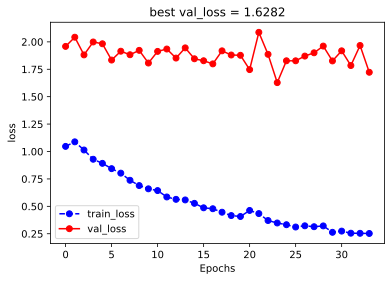

epoch,train_loss,lr,val_loss
0.0,1.0466746859825575,0.0,1.9584742188453674
1.0,1.0882555865324461,0.0001,2.0423943996429443
2.0,1.0138011677907064,0.0001,1.881056547164917
3.0,0.9293790092835059,0.0001,1.9988568425178528
4.0,0.8921603663609579,0.0001,1.9824714064598083
5.0,0.8436770129662293,0.0001,1.8339663743972778
6.0,0.8026805772231176,0.0001,1.914647102355957
7.0,0.7376368332367677,0.0001,1.8825665712356567
8.0,0.6893776380098783,0.0001,1.9225164651870728
9.0,0.6597859561443329,0.0001,1.806775689125061



================================================================================2023-03-10 09:40:38
Epoch 0 / 100

100%|██████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.45it/s, val_loss=1.96]
<<<<<< reach best val_loss : 1.9584742188453674 >>>>>>

================================================================================2023-03-10 09:40:54
Epoch 1 / 100

100%|██████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.53it/s, val_loss=2.04]

================================================================================2023-03-10 09:41:16
Epoch 2 / 100

100%|██████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.12it/s, val_loss=1.88]
<<<<<< reach best val_loss : 1.881056547164917 >>>>>>

================================================================================2023-03-10 09:41:38
Epoch 3 / 100

100%|█████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.26it/s, val_loss=2]

======================

In [21]:
%matplotlib inline 
%config InlineBackend.figure_format = 'svg'
dfhistory = keras_model.fit(
    train_data = dl_train,
    val_data=dl_val,
    epochs=100,
    ckpt_path='checkpoint.pt',
    patience=10,
    monitor='val_loss',
    mode='min',
    mixed_precision='no',
    plot=True
)

## 四，使用模型

In [23]:
model.eval();

def pipe(model,img_path):
    img = Image.open(img_path).convert("RGB")
    img_tensor = transforms_val(img,None)[0]
    
    inputs = img_tensor[None,...].cuda()
    # 预测结果
    with torch.no_grad():
        prediction = model(inputs)[0]
    boxes = prediction['boxes']
    boxes[:,0] = boxes[:,0]*img.width 
    boxes[:,1] = boxes[:,1]*img.height
    boxes[:,2] = boxes[:,2]*img.width 
    boxes[:,3] = boxes[:,3]*img.height
    prediction['boxes'] = boxes
    return prediction 

    
        

In [24]:
# 准备数据
img_path = os.path.join(val_images_path,os.listdir(val_images_path)[2])
img = Image.open(img_path)

In [26]:
img = Image.open(img_path).convert("RGB")
img_tensor = transforms_val(img,None)[0]

inputs = img_tensor[None,...].cuda()
    

In [27]:
prediction = pipe(model,img_path)

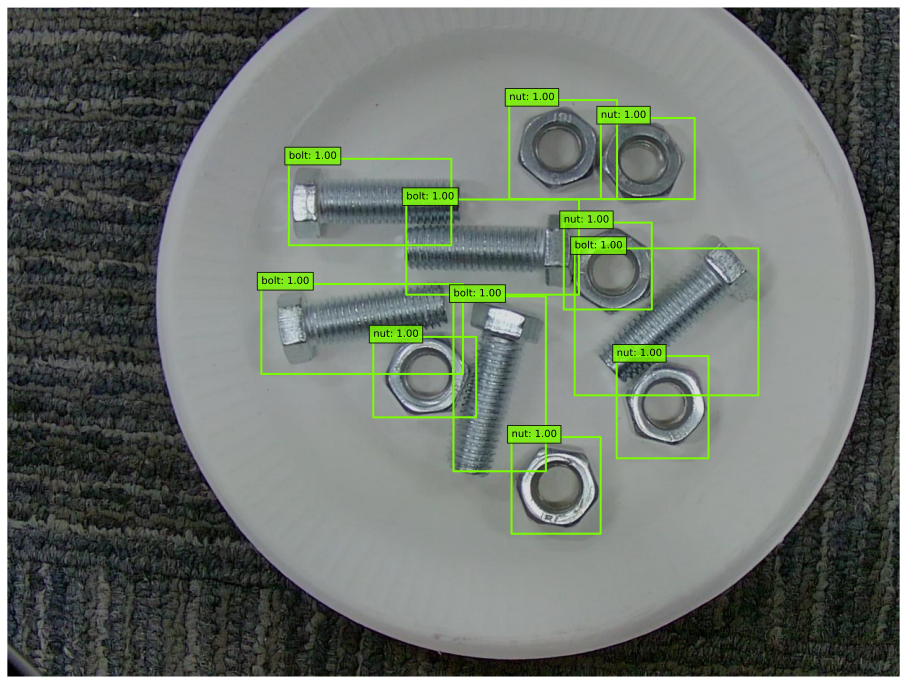

In [28]:
# 结果可视化
img_result = vis_detection(img,prediction,class_names,min_score = 0.5)

## 五，评估模型

In [ ]:
!pip install pycocotools 

In [29]:
from pycocotools import coco,cocoeval
import pycocotools
from tqdm import tqdm
import numpy as np 
import pandas as pd

def coco_evaluate(gts, preds, classes=name2idxs.keys()):
    '''
    object detection performance evaluation on customized dataset
    gts: list of ground truth object boundingboxes, in form of 
         [[[class_1, x1, y1, x2, y2], # the first object in the first image
           [class_2, x1, y1, x2, y2], # the second object in the first image
           ...
          ],
          [[class_1, x1, y1, x2, y2], # the first object in the second image
           [class_2, x1, y1, x2, y2], # the second object in the second image
           ...
          ]
         ]
    preds: list of predicted object boundingboxes, in form of
        [[[class_1, score, x1, y1, x2, y2], # the first object in the first image
           [class_2, score, x1, y1, x2, y2], # the second object in the first image
           ...
          ],
          [[class_1, score, x1, y1, x2, y2], # the first object in the second image
           [class_2, score, x1, y1, x2, y2], # the second object in the second image
           ...
          ]
         ]
    '''
    coco_gt = pycocotools.coco.COCO()
    coco_gt.dataset = {}
    coco_gt.dataset["images"] = []
    coco_gt.dataset["annotations"] = []
    k = 0
    for i, gt in enumerate(gts):
        for j in range(gt.shape[0]):
            coco_gt.dataset["images"].append({"id": i})
            coco_gt.dataset["annotations"].append({"image_id": i, "category_id": np.int(gt[j, 0]),
                                                   "bbox": np.hstack([gt[j, 1:3], gt[j, 3:5] - gt[j, 1:3]]),
                                                   "area": np.prod(gt[j, 3:5] - gt[j, 1:3]),
                                                   "id": k, "iscrowd": 0})
            k += 1
            pass
        pass
    coco_gt.dataset["categories"] = [{"id": i, "supercategory": c, "name": c} for i, c in enumerate(classes)]
    coco_gt.createIndex()

    coco_pred = pycocotools.coco.COCO()
    coco_pred.dataset = {}
    coco_pred.dataset["images"] = []
    coco_pred.dataset["annotations"] = []
    k = 0
    for i, pred in enumerate(preds):
        for j in range(pred.shape[0]):
            coco_pred.dataset["images"].append({"id": i})
            coco_pred.dataset["annotations"].append({"image_id": i, "category_id": np.int(pred[j, 0]),
                                                     "score": pred[j, 1], "bbox": np.hstack([pred[j, 2:4], pred[j, 4:6] - pred[j, 2:4]]),
                                                     "area": np.prod(pred[j, 4:6] - pred[j, 2:4]),
                                                     "id": k, "iscrowd": 0})
            k += 1
            pass
        pass
    coco_pred.dataset["categories"] = [{"id": i, "supercategory": c, "name": c} for i, c in enumerate(classes)]
    coco_pred.createIndex()

    coco_eval = pycocotools.cocoeval.COCOeval(coco_gt, coco_pred, "bbox")
    coco_eval.params.imgIds = coco_gt.getImgIds()
    coco_eval.evaluate()
    coco_eval.accumulate()
    coco_eval.summarize()
    return

def listdict_to_listarr(data):
    result = []
    
    sample = data[0]
    
    assert 'boxes' in sample.keys() and ('classes' in sample.keys() or 'labels' in sample.keys())
    
    label_key = 'classes' if 'classes' in sample.keys() else 'labels'
    
    if 'scores' not in sample.keys():
        for sample in tqdm(data):
            classes = sample[label_key].tolist()
            boxes = sample['boxes'].tolist() 
            arr = np.array([[a]+b for a,b in zip(classes,boxes)])
            result.append(arr)
    else:
        for sample in tqdm(data):
            classes = sample[label_key].tolist()
            scores = sample['scores'].tolist()
            boxes = sample['boxes'].tolist() 
            arr = np.array([[a]+[b]+c for a,b,c in zip(classes,scores,boxes)])
            result.append(arr)
            
    return result


def compute_iou(boxes1, boxes2):
    """Computes pairwise IOU matrix for given two sets of boxes
    """
    lu = np.maximum(boxes1[:, None, :2], boxes2[:, :2])
    rd = np.minimum(boxes1[:, None, 2:], boxes2[:, 2:])
    intersection = np.maximum(0.0, rd - lu)
    intersection_area = intersection[:, :, 0] * intersection[:, :, 1]
    boxes1_area = (boxes1[:, 2]-boxes1[:, 0]) * (boxes1[:, 3]-boxes1[:, 1])
    boxes2_area = (boxes2[:, 2]-boxes2[:, 0]) * (boxes2[:, 3]-boxes2[:, 1])
    union_area = np.maximum(
        boxes1_area[:, None] + boxes2_area - intersection_area, 1e-8
    )
    return np.clip(intersection_area / union_area, 0.0, 1.0)

def get_class_pr(gts,preds,class_idx,conf_th=0.5,iou_th=0.5):
    num_precision,num_recall,num_pred,num_gt = 0,0,0,0
    
    for idx in range(len(preds)):
        gt = gts[idx]
        pred = preds[idx]
        
        
        if len(gt)==0:
            if len(pred)>0:
                pred_cls = pred[(pred[:,0]==class_idx)&(pred[:,1]>conf_th)]
                num_pred+=len(pred_cls)
            continue
        
        if len(pred)==0:
            if len(gt)>0:
                gt_cls = gt[gt[:,0]==class_idx]
                num_gt+=len(gt_cls)
            continue
            
        gt_cls = gt[gt[:,0]==class_idx]
        pred_cls = pred[(pred[:,0]==class_idx)&(pred[:,1]>conf_th)]
        
        if len(gt_cls)==0 or len(pred_cls)==0:
            continue
    
        iou = compute_iou(pred_cls[:,2:],gt_cls[:,1:])
        
        num_precision_idx = np.sum(np.max(iou,axis=1)>iou_th) 
        num_recall_idx = np.sum(np.max(iou,axis=0)>iou_th) 
        
        num_pred_idx = len(pred_cls)
        num_gt_idx = len(gt_cls)
        
        num_precision+=num_precision_idx
        num_recall+=num_recall_idx
        
        num_pred+=num_pred_idx
        num_gt+=num_gt_idx
    
    precision = num_precision/max(num_pred,1)
    recall = num_recall/max(num_gt,1)
    
    return num_gt, precision,recall 

# 计算每种类别的precision和recall
def pr_evaluate(gts,preds,idx2names,conf_th=0.8,iou_th=0.2):
    num_images =  len(gts)
    dfstats = pd.DataFrame(columns = ['Class','Images','Instances','Precision','Recall'])  
    for str_idx in idx2names.keys():
        class_idx = int(str_idx)
        if class_idx>0:
            num_gt, precision,recall = get_class_pr(gts,preds,class_idx,conf_th=conf_th,iou_th=iou_th)
            dfstats.loc[len(dfstats)] = {
                'Class':idx2names[str(class_idx)],
                'Images':num_images,
                'Instances':num_gt,
                'Precision':precision,
                'Recall':recall}
    all_instances = dfstats['Instances'].sum()
    mean_precision = dfstats['Precision'].mean()
    mean_recall = dfstats['Recall'].mean()
    
    dfall = pd.DataFrame({'Class':['all'],'Images':[num_images],
                          'Instances':[all_instances],'Precision':[mean_precision],
                          'Recall':[mean_recall]})
    dfout = pd.concat([dfall,dfstats],ignore_index=True)
    return dfout 


In [30]:
from tqdm import tqdm 

ground_truths = []
for batch in dl_val:
    ground_truths.extend(list(batch[1]))
    

gts = listdict_to_listarr(ground_truths)


100%|██████████| 10/10 [00:00<00:00, 23537.06it/s]


In [31]:
model.to('cpu')
model.eval()

predictions = []
for batch in dl_val:
    features,labels = batch 
    predictions.extend(model(features))

preds = listdict_to_listarr(predictions)      

100%|██████████| 10/10 [00:00<00:00, 10379.37it/s]


In [32]:
metrics = coco_evaluate(gts,preds)

creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.03s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.108
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.237
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.094
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.108
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.045
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.241
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.241
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.241
 

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:39: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:57: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecat

In [33]:
pr_evaluate(gts,preds,idx2names)


,Class,Images,Instances,Precision,Recall
0,all,10,107,0.666848,0.680015
1,bolt,10,38,0.725000,0.736842
2,nut,10,69,0.608696,0.623188


## 六，保存模型

In [34]:
#保存模型参数
torch.save(model.state_dict(), "ssd_boltnut.pt")

**如果本项目对你有所帮助，想鼓励一下作者，记得给本项目加一颗星星star⭐️，并分享给你的朋友们喔😊!** 

如果在torchkeras的使用中遇到问题，可以在项目中提交issue。

如果想要获得更快的反馈或者与其他torchkeras用户小伙伴进行交流，

可以在公众号算法美食屋后台回复关键字：**加群**。

![](https://tva1.sinaimg.cn/large/e6c9d24egy1h41m2zugguj20k00b9q46.jpg)